# Premier League Betting Odds Models
### STAT 5603 Group Project by Evan Gagne, Aaron Mittleman, Maame Yaa Afaribea Martinson, and Suryakala Venkatakrishnan

The modern English Premier League, founded in 1993, is the highest level of football (soccer) in the country. Our dataset from Kaggle includes every matche played from the start of the league through today. The data includes the result of the match, the home and away teams, the number of goals scored, the number of penalties scored, and more. 

Betting odds from Bet365, a sportsbook, are included starting in the 2002-2003 season for the home/away team winning and for the total goals scored being over or under 2.5. The goal of our project is to build models that predict the betting odds. This model can be used by a betting company looking to set their own odds or by someone who wants to bet on games. If the odds from the model are much higher than what Bet365 has currently set for the game, this should be a bet where you're more likely to win.

## Data import and cleaning

The first step is to import the dataset and all packages we need to start basic exploratory analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
PL = pd.read_csv('PremierLeague.csv')
PL.head()

,Season,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,FullTimeResult,HalfTimeHomeTeamGoals,HalfTimeAwayTeamGoals,...,MarketMaxHomeTeam,MarketMaxDraw,MarketMaxAwayTeam,MarketAvgHomeTeam,MarketAvgDraw,MarketAvgAwayTeam,MarketMaxOver2.5Goals,MarketMaxUnder2.5Goals,MarketAvgOver2.5Goals,MarketAvgUnder2.5Goals
0,1993-1994,14/08/93,NaN,Arsenal,Coventry,0,3,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-1994,14/08/93,NaN,Aston Villa,QPR,4,1,H,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-1994,14/08/93,NaN,Chelsea,Blackburn,1,2,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-1994,14/08/93,NaN,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-1994,14/08/93,NaN,Man City,Leeds,1,1,D,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
len(PL)

11723

A little bit of cleaning before going forward: Renaming one column with a typo in the title to avoid future mistakes and removing betting-related columns we're not using for our models.

In [4]:
PL = PL.rename(columns={'AwayTeamReadCards': 'AwayTeamRedCards'})

PL = PL.loc[:,~PL.columns.str.startswith('Market')]

In [5]:
PL.dtypes

Season                    object
Date                      object
Time                      object
HomeTeam                  object
AwayTeam                  object
FullTimeHomeTeamGoals      int64
FullTimeAwayTeamGoals      int64
FullTimeResult            object
HalfTimeHomeTeamGoals    float64
HalfTimeAwayTeamGoals    float64
HalfTimeResult            object
Referee                   object
HomeTeamShots            float64
AwayTeamShots            float64
HomeTeamShotsOnTarget    float64
AwayTeamShotsOnTarget    float64
HomeTeamCorners          float64
AwayTeamCorners          float64
HomeTeamFouls            float64
AwayTeamFouls            float64
HomeTeamYellowCards      float64
AwayTeamYellowCards      float64
HomeTeamRedCards         float64
AwayTeamRedCards         float64
B365HomeTeam             float64
B365Draw                 float64
B365AwayTeam             float64
B365Over2.5Goals         float64
B365Under2.5Goals        float64
dtype: object

In [6]:
PL.isnull().sum()

Season                      0
Date                        0
Time                     9880
HomeTeam                    0
AwayTeam                    0
FullTimeHomeTeamGoals       0
FullTimeAwayTeamGoals       0
FullTimeResult              0
HalfTimeHomeTeamGoals     760
HalfTimeAwayTeamGoals     760
HalfTimeResult            760
Referee                  2660
HomeTeamShots            2660
AwayTeamShots            2660
HomeTeamShotsOnTarget    2660
AwayTeamShotsOnTarget    2660
HomeTeamCorners          2660
AwayTeamCorners          2660
HomeTeamFouls            2660
AwayTeamFouls            2660
HomeTeamYellowCards      2660
AwayTeamYellowCards      2660
HomeTeamRedCards         2660
AwayTeamRedCards         2660
B365HomeTeam             3420
B365Draw                 3420
B365AwayTeam             3420
B365Over2.5Goals         8877
B365Under2.5Goals        8877
dtype: int64

Below we are creating new features that can be used for future predictions. We are using the average of each team's last 10 games to create these features. We are doing this for goals, shots, corners, yellow cards, red cards, and fouls. We are also creating a column that calculates the win percentage from the last 10 games.

In [7]:
#Helper function to calculate the rolling average from the last 10 games of a given column
def last_ten_avg(column):
  rolling_avg_H = grouped[column].rolling(window=10, min_periods=1, closed='left').mean() #closed=left excludes the last row (i.e. only past games get averaged)
  rolling_avg_H = rolling_avg_H.reset_index(level=0, drop=True)
  colname = column + 'Last10Avg'
  PL[colname] = rolling_avg_H

In [8]:
grouped = PL.groupby('HomeTeam')
last_ten_avg('FullTimeHomeTeamGoals')
last_ten_avg('HomeTeamShots')
last_ten_avg('HomeTeamCorners')
last_ten_avg('HomeTeamFouls')
last_ten_avg('HomeTeamYellowCards')
last_ten_avg('HomeTeamRedCards')

In [9]:
grouped = PL.groupby('AwayTeam')
last_ten_avg('FullTimeAwayTeamGoals')
last_ten_avg('AwayTeamShots')
last_ten_avg('AwayTeamCorners')
last_ten_avg('AwayTeamFouls')
last_ten_avg('AwayTeamYellowCards')
last_ten_avg('AwayTeamRedCards')

In [10]:
win_percent_df = pd.DataFrame()
for result in ['H', 'A', 'D']:
    win_counts = (PL['FullTimeResult'] == result).rolling(window=10, min_periods=1, closed='left').sum()
    win_percent = (win_counts / 10) * 100
    var_name = 'WinPercent_' + result
    win_percent_df[var_name] = win_percent
PL2 = pd.concat([PL, win_percent_df], axis=1)

In [11]:
PL2.head(-1000)

,Season,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,FullTimeResult,HalfTimeHomeTeamGoals,HalfTimeAwayTeamGoals,...,HomeTeamRedCardsLast10Avg,FullTimeAwayTeamGoalsLast10Avg,AwayTeamShotsLast10Avg,AwayTeamCornersLast10Avg,AwayTeamFoulsLast10Avg,AwayTeamYellowCardsLast10Avg,AwayTeamRedCardsLast10Avg,WinPercent_H,WinPercent_A,WinPercent_D
0,1993-1994,14/08/93,NaN,Arsenal,Coventry,0,3,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-1994,14/08/93,NaN,Aston Villa,QPR,4,1,H,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.0,0.0
2,1993-1994,14/08/93,NaN,Chelsea,Blackburn,1,2,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0
3,1993-1994,14/08/93,NaN,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,20.0,0.0
4,1993-1994,14/08/93,NaN,Man City,Leeds,1,1,D,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10718,2021-2022,17/10/21,4:30:00 PM,Newcastle,Tottenham,2,3,A,1.0,3.0,...,0.1,1.5,8.9,4.1,11.1,1.8,0.2,30.0,50.0,20.0
10719,2021-2022,18/10/21,8:00:00 PM,Arsenal,Crystal Palace,2,2,D,1.0,0.0,...,0.0,1.0,8.8,4.1,10.3,1.1,0.0,30.0,50.0,20.0
10720,2021-2022,22/10/21,8:00:00 PM,Arsenal,Aston Villa,3,1,H,2.0,0.0,...,0.0,1.2,14.2,5.5,11.7,2.0,0.0,30.0,50.0,20.0
10721,2021-2022,23/10/21,12:30:00 PM,Chelsea,Norwich,7,0,H,3.0,0.0,...,0.1,0.1,7.6,2.6,8.2,2.1,0.0,40.0,40.0,20.0


Next, we check for any variable types that need to be changed and for null values.

In [12]:
PL2.dtypes

Season                             object
Date                               object
Time                               object
HomeTeam                           object
AwayTeam                           object
FullTimeHomeTeamGoals               int64
FullTimeAwayTeamGoals               int64
FullTimeResult                     object
HalfTimeHomeTeamGoals             float64
HalfTimeAwayTeamGoals             float64
HalfTimeResult                     object
Referee                            object
HomeTeamShots                     float64
AwayTeamShots                     float64
HomeTeamShotsOnTarget             float64
AwayTeamShotsOnTarget             float64
HomeTeamCorners                   float64
AwayTeamCorners                   float64
HomeTeamFouls                     float64
AwayTeamFouls                     float64
HomeTeamYellowCards               float64
AwayTeamYellowCards               float64
HomeTeamRedCards                  float64
AwayTeamRedCards                  

In [13]:
PL2.isnull().sum()

Season                               0
Date                                 0
Time                              9880
HomeTeam                             0
AwayTeam                             0
FullTimeHomeTeamGoals                0
FullTimeAwayTeamGoals                0
FullTimeResult                       0
HalfTimeHomeTeamGoals              760
HalfTimeAwayTeamGoals              760
HalfTimeResult                     760
Referee                           2660
HomeTeamShots                     2660
AwayTeamShots                     2660
HomeTeamShotsOnTarget             2660
AwayTeamShotsOnTarget             2660
HomeTeamCorners                   2660
AwayTeamCorners                   2660
HomeTeamFouls                     2660
AwayTeamFouls                     2660
HomeTeamYellowCards               2660
AwayTeamYellowCards               2660
HomeTeamRedCards                  2660
AwayTeamRedCards                  2660
B365HomeTeam                      3420
B365Draw                 

## Exploratory analysis

We can check the distribution of the new features and their correlations below.

(array([7.500e+01, 1.394e+03, 4.425e+03, 3.409e+03, 1.518e+03, 6.280e+02,
        1.780e+02, 3.200e+01, 1.100e+01, 2.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

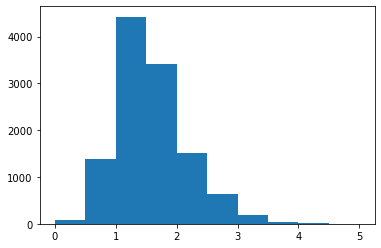

In [14]:
#change these to plt or pandas plots and it's one fewer package to bother with
plt.hist(data=PL, x='FullTimeHomeTeamGoalsLast10Avg')

(array([2.230e+02, 2.211e+03, 4.938e+03, 2.111e+03, 1.405e+03, 6.500e+02,
        1.050e+02, 2.100e+01, 5.000e+00, 3.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

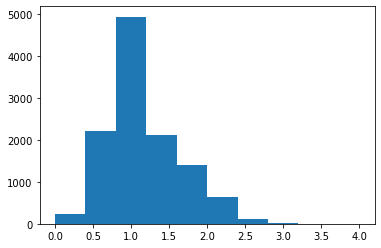

In [15]:
plt.hist(data=PL, x='FullTimeAwayTeamGoalsLast10Avg')

(array([   6.,  117., 1326., 2936., 2480., 1270.,  624.,  227.,   26.,
           5.]),
 array([ 4.  ,  6.27,  8.54, 10.81, 13.08, 15.35, 17.62, 19.89, 22.16,
        24.43, 26.7 ]),
 <BarContainer object of 10 artists>)

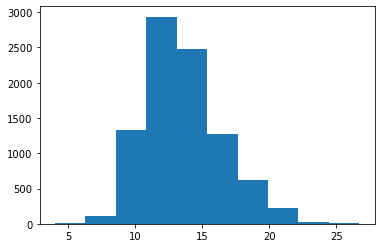

In [16]:
plt.hist(data=PL, x='HomeTeamShotsLast10Avg')

(array([  15.,  122., 1034., 2618., 2383., 1604.,  774.,  332.,  103.,
          32.]),
 array([ 3.  ,  4.73,  6.46,  8.19,  9.92, 11.65, 13.38, 15.11, 16.84,
        18.57, 20.3 ]),
 <BarContainer object of 10 artists>)

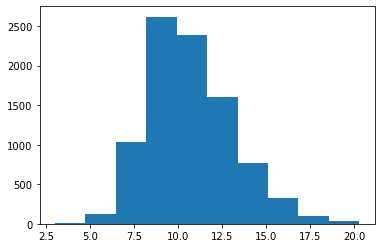

In [17]:
plt.hist(data=PL, x='AwayTeamShotsLast10Avg')

(array([   3.,   15.,   69.,  765., 2595., 2797., 1748.,  750.,  227.,
          48.]),
 array([ 0.  ,  1.11,  2.22,  3.33,  4.44,  5.55,  6.66,  7.77,  8.88,
         9.99, 11.1 ]),
 <BarContainer object of 10 artists>)

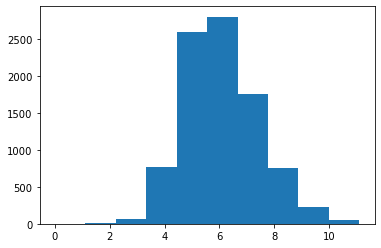

In [18]:
plt.hist(data=PL, x='HomeTeamCornersLast10Avg')

(array([  16.,  274., 1801., 3218., 2402., 1004.,  235.,   54.,    6.,
           7.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

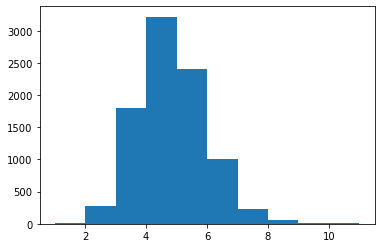

In [19]:
plt.hist(data=PL, x='AwayTeamCornersLast10Avg')

In [20]:
new_features_numerical_columns_BET365 = PL2[['B365HomeTeam','B365Draw','B365AwayTeam','B365Over2.5Goals','B365Under2.5Goals',
                                             'AwayTeamYellowCardsLast10Avg','HomeTeamYellowCardsLast10Avg',
                                             'HomeTeamRedCardsLast10Avg','AwayTeamRedCardsLast10Avg',
                                             'HomeTeamFoulsLast10Avg','AwayTeamFoulsLast10Avg',
                                             'HomeTeamCornersLast10Avg','AwayTeamCornersLast10Avg',
                                             'AwayTeamShotsLast10Avg','HomeTeamShotsLast10Avg',
                                             'FullTimeAwayTeamGoalsLast10Avg','FullTimeHomeTeamGoalsLast10Avg',
                                              'WinPercent_H','WinPercent_A','WinPercent_D']]

In [21]:
new_features_numerical_columns_BET365.corr().round(2)

,B365HomeTeam,B365Draw,B365AwayTeam,B365Over2.5Goals,B365Under2.5Goals,AwayTeamYellowCardsLast10Avg,HomeTeamYellowCardsLast10Avg,HomeTeamRedCardsLast10Avg,AwayTeamRedCardsLast10Avg,HomeTeamFoulsLast10Avg,AwayTeamFoulsLast10Avg,HomeTeamCornersLast10Avg,AwayTeamCornersLast10Avg,AwayTeamShotsLast10Avg,HomeTeamShotsLast10Avg,FullTimeAwayTeamGoalsLast10Avg,FullTimeHomeTeamGoalsLast10Avg,WinPercent_H,WinPercent_A,WinPercent_D
B365HomeTeam,1.00,0.02,-0.49,-0.11,0.10,-0.04,0.14,0.02,-0.03,0.05,-0.20,-0.26,0.40,0.54,-0.30,0.50,-0.33,0.03,-0.01,-0.03
B365Draw,0.02,1.00,0.81,-0.68,0.82,0.01,-0.08,-0.07,-0.04,-0.25,-0.13,0.29,-0.04,0.03,0.46,-0.02,0.47,-0.03,0.05,-0.02
B365AwayTeam,-0.49,0.81,1.00,-0.41,0.52,0.02,-0.18,-0.08,0.00,-0.20,0.07,0.39,-0.25,-0.31,0.53,-0.32,0.55,-0.04,0.03,0.01
B365Over2.5Goals,-0.11,-0.68,-0.41,1.00,-0.90,-0.13,-0.08,0.01,0.08,0.25,0.20,-0.25,-0.13,-0.30,-0.46,-0.26,-0.49,0.01,-0.03,0.03
B365Under2.5Goals,0.10,0.82,0.52,-0.90,1.00,0.14,0.07,-0.03,-0.10,-0.30,-0.23,0.24,0.07,0.26,0.49,0.20,0.49,-0.02,0.05,-0.04
AwayTeamYellowCardsLast10Avg,-0.04,0.01,0.02,-0.13,0.14,1.00,0.07,0.03,0.09,0.01,0.29,0.00,-0.10,-0.07,0.03,-0.03,0.02,0.02,-0.01,-0.01
HomeTeamYellowCardsLast10Avg,0.14,-0.08,-0.18,-0.08,0.07,0.07,1.00,0.10,-0.03,0.23,-0.13,-0.19,-0.04,0.08,-0.16,0.04,-0.22,0.02,0.02,-0.04
HomeTeamRedCardsLast10Avg,0.02,-0.07,-0.08,0.01,-0.03,0.03,0.10,1.00,0.03,0.18,0.05,-0.08,-0.00,-0.03,-0.14,-0.01,-0.12,-0.00,0.00,0.00
AwayTeamRedCardsLast10Avg,-0.03,-0.04,0.00,0.08,-0.10,0.09,-0.03,0.03,1.00,0.09,0.12,0.02,-0.02,-0.10,-0.00,-0.08,0.00,-0.01,-0.00,0.02
HomeTeamFoulsLast10Avg,0.05,-0.25,-0.20,0.25,-0.30,0.01,0.23,0.18,0.09,1.00,0.33,-0.07,-0.01,-0.18,-0.29,-0.07,-0.21,0.03,-0.06,0.03


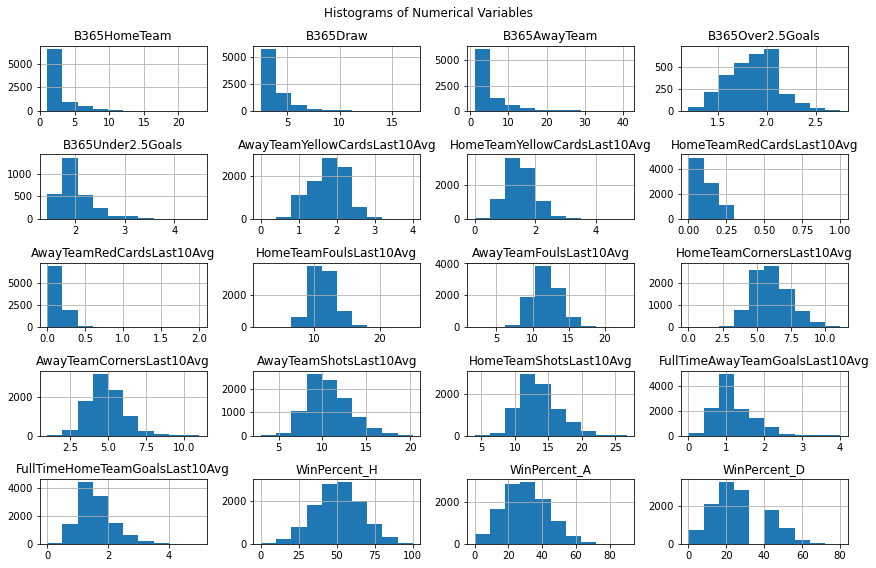

In [22]:
new_features_numerical_columns_BET365.hist(figsize=(12, 8))
plt.suptitle("Histograms of Numerical Variables")
plt.tight_layout()
plt.show()

Betting odds are not available for all seasons in the data. Now that we are ready to try creating models, we will limit the data to just those matches that have odds.

In [23]:
PL_bet = PL2[(PL2["B365HomeTeam"].notnull()) & (PL2["B365Over2.5Goals"].notnull())]

In [24]:
PL_bet.isnull().sum()

Season                               0
Date                                 0
Time                              1004
HomeTeam                             0
AwayTeam                             0
FullTimeHomeTeamGoals                0
FullTimeAwayTeamGoals                0
FullTimeResult                       0
HalfTimeHomeTeamGoals                0
HalfTimeAwayTeamGoals                0
HalfTimeResult                       0
Referee                              0
HomeTeamShots                        0
AwayTeamShots                        0
HomeTeamShotsOnTarget                0
AwayTeamShotsOnTarget                0
HomeTeamCorners                      0
AwayTeamCorners                      0
HomeTeamFouls                        0
AwayTeamFouls                        0
HomeTeamYellowCards                  0
AwayTeamYellowCards                  0
HomeTeamRedCards                     0
AwayTeamRedCards                     0
B365HomeTeam                         0
B365Draw                 

In [25]:
PL_bet.head(100)

,Season,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,FullTimeResult,HalfTimeHomeTeamGoals,HalfTimeAwayTeamGoals,...,HomeTeamRedCardsLast10Avg,FullTimeAwayTeamGoalsLast10Avg,AwayTeamShotsLast10Avg,AwayTeamCornersLast10Avg,AwayTeamFoulsLast10Avg,AwayTeamYellowCardsLast10Avg,AwayTeamRedCardsLast10Avg,WinPercent_H,WinPercent_A,WinPercent_D
3549,2002-2003,16/11/02,NaN,Arsenal,Tottenham,3,0,H,1.0,0.0,...,0.0,1.1,8.7,5.3,13.2,1.8,0.0,70.0,10.0,20.0
3550,2002-2003,16/11/02,NaN,Chelsea,Middlesbrough,1,0,H,0.0,0.0,...,0.0,0.6,9.6,5.6,13.1,1.3,0.1,70.0,10.0,20.0
3551,2002-2003,16/11/02,NaN,Man City,Charlton,0,1,A,0.0,0.0,...,0.3,0.5,8.5,5.7,12.1,1.6,0.0,70.0,10.0,20.0
3552,2002-2003,16/11/02,NaN,Newcastle,Southampton,2,1,H,1.0,1.0,...,0.0,0.7,10.3,5.0,12.7,1.2,0.2,70.0,20.0,10.0
3553,2002-2003,16/11/02,NaN,West Brom,Aston Villa,0,0,D,0.0,0.0,...,0.0,0.9,12.2,5.9,13.6,1.2,0.0,70.0,20.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,2002-2003,11/01/03,NaN,West Ham,Newcastle,2,2,D,2.0,1.0,...,0.1,1.4,9.8,5.2,12.4,1.5,0.1,50.0,10.0,40.0
3645,2002-2003,12/01/03,NaN,Birmingham,Arsenal,0,4,A,0.0,2.0,...,0.1,1.7,8.5,5.4,13.9,2.1,0.2,40.0,10.0,50.0
3646,2002-2003,12/01/03,NaN,Tottenham,Everton,4,3,H,1.0,1.0,...,0.1,0.8,10.5,5.1,16.7,1.6,0.3,30.0,20.0,50.0
3647,2002-2003,18/01/03,NaN,Aston Villa,Tottenham,0,1,A,0.0,0.0,...,0.2,1.0,8.7,4.9,11.7,1.5,0.2,30.0,20.0,50.0


In [26]:
PL_bet.dtypes

Season                             object
Date                               object
Time                               object
HomeTeam                           object
AwayTeam                           object
FullTimeHomeTeamGoals               int64
FullTimeAwayTeamGoals               int64
FullTimeResult                     object
HalfTimeHomeTeamGoals             float64
HalfTimeAwayTeamGoals             float64
HalfTimeResult                     object
Referee                            object
HomeTeamShots                     float64
AwayTeamShots                     float64
HomeTeamShotsOnTarget             float64
AwayTeamShotsOnTarget             float64
HomeTeamCorners                   float64
AwayTeamCorners                   float64
HomeTeamFouls                     float64
AwayTeamFouls                     float64
HomeTeamYellowCards               float64
AwayTeamYellowCards               float64
HomeTeamRedCards                  float64
AwayTeamRedCards                  

We can replace any null values with 0.

In [27]:
PL_bet.fillna(0, inplace=True)

/var/folders/pm/pg7vykvs70j4hx_8y76ydrrh0000gn/T/ipykernel_29925/3829608582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PL_bet.fillna(0, inplace=True)


In [28]:
PL_model = PL_bet[['B365HomeTeam','B365Draw','B365AwayTeam','B365Over2.5Goals','B365Under2.5Goals',
                    'AwayTeamYellowCardsLast10Avg','HomeTeamYellowCardsLast10Avg',
                   'HomeTeamRedCardsLast10Avg','AwayTeamRedCardsLast10Avg',
                   'HomeTeamFoulsLast10Avg','AwayTeamFoulsLast10Avg',
                   'HomeTeamCornersLast10Avg','AwayTeamCornersLast10Avg',
                   'AwayTeamShotsLast10Avg','HomeTeamShotsLast10Avg',
                   'FullTimeAwayTeamGoalsLast10Avg','FullTimeHomeTeamGoalsLast10Avg',
                   'WinPercent_H','WinPercent_A','WinPercent_D']]

Finally, we will examine the logs of our numerical variables to see if their distributions would be more favorable for modeling.

A small constant is added in order to be able to log transform the features. This allows us to get rid of any 0 values in the data frame.

In [29]:
small_const = 1e-9
lg_data = np.log(PL_model+small_const)

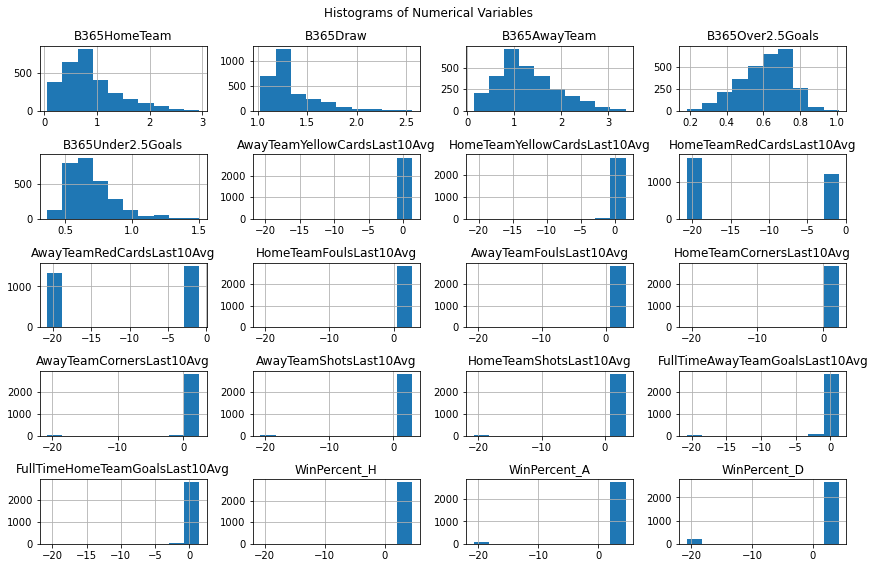

In [30]:
lg_data.hist(figsize=(12, 8))
plt.suptitle("Histograms of Numerical Variables")
plt.tight_layout()
plt.show()

The non transformed data was used because the transformed data does not appear to be significantly improved.

## Modeling

Finally, we are ready to model. First, importing sklearn libraries:

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First, we will test Linear Regression, KNN, and Random Forest models for predicting the odds of the home team winning.

In [32]:
X = PL_model.drop(columns=['B365HomeTeam','B365Draw','B365AwayTeam','B365Over2.5Goals','B365Under2.5Goals'])
y = PL_model['B365HomeTeam']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
#use cross validation to select best model then train and test that model.
cvdata = KFold(n_splits=5, random_state=42, shuffle=True)

In [35]:
#Function to create a linear regression model and find its r^2
def linear_regression(X, y):
    linearReg_pipeline = make_pipeline(StandardScaler(), LinearRegression())
    scores = cross_val_score(linearReg_pipeline, X, y, cv=cvdata)
    print("Linear regression:", scores.mean())
    
linear_regression(X, y)

Linear regression: 0.49453617440045405


In [36]:
#Function to find the optimal K and highest r^2
def KNN(X, y):
    Rsquared = []
    for k in range(1,100):
        knn_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=k))
        scores = cross_val_score(knn_pipeline, X, y, cv=cvdata, scoring='r2')
        Rsquared.append(scores.mean())
    print("KNN:", max(Rsquared), "at k =", range(1,100)[np.argmax(Rsquared)])
    
KNN(X, y)

KNN: 0.5758513831722644 at k = 8


In [37]:
#Function to create and validate a random forest model
def random_forest(X, y):
    randomForest_pipeline = Pipeline([
        ('preprocessor', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=50, random_state=42))
    ])

    scores = cross_val_score(randomForest_pipeline, X, y, cv=cvdata)
    print("Random forest:", scores.mean())
    
random_forest(X, y)

Random forest: 0.6095531733428915


The Random Forest model has the highest $R^2$, followed by KNN and linear regression respectively. If we simply want the best-fit model, we should use the random forest to fit the data and run predictions. However, the linear model is close enough to be acceptable, while being much faster and easier to interpret. We will continue to fit all models for the remaining odds variables, but later we just examine linear models.

Now, we will test linear regression, KNN, and random forest models for Away odds, Draw odds, and Over/Under 2.5 goals.

In [38]:
ys = []
y1 = PL_model['B365AwayTeam']
ys.append(y1)
y2 = PL_model['B365Draw']
ys.append(y2)
y3 = PL_model['B365Over2.5Goals']
ys.append(y3)
y4 = PL_model['B365Under2.5Goals']
ys.append(y4)

for y in ys:
    print(y.name)
    linear_regression(X, y)
    KNN(X, y)
    random_forest(X, y)
    print("\n")

B365AwayTeam
Linear regression: 0.5244834732317194
KNN: 0.5823292756955784 at k = 18
Random forest: 0.6286640262145455


B365Draw
Linear regression: 0.2978351638616479
KNN: 0.518121663916595 at k = 9
Random forest: 0.5573668441171278


B365Over2.5Goals
Linear regression: 0.40366107890827096
KNN: 0.43493953207908226 at k = 17
Random forest: 0.47370649570592605


B365Under2.5Goals
Linear regression: 0.4108331589194413
KNN: 0.49710630972102543 at k = 14
Random forest: 0.5176945530908055




## Fit the linear regression models
As mentioned earlier we will use the linear models because they are close to as good as the random forest model and give us the ability to explain the effects that the features have on the outcome as well as being the faster models.

In [39]:
def model_mse(x, y):
    model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

We can use the models and find the MSE for each model below.

In [40]:
print("The MSE for the Home odds is", model_mse(X, y))
print("The MSE for the Away odds is", model_mse(X, y1))
print("The MSE for the Draw odds is", model_mse(X, y2))
print("The MSE for the Over 2.5 goals odds is", model_mse(X, y3))
print("The MSE for the Under 2.5 goals odds is", model_mse(X, y4))

The MSE for the Home odds is 0.07650758155568843
The MSE for the Away odds is 5.400709859253928
The MSE for the Draw odds is 0.8367282001626561
The MSE for the Over 2.5 goals odds is 0.03160878939908875
The MSE for the Under 2.5 goals odds is 0.07650758155568843


## Conclusion
The models are good predictors of the odds and can be used to predict odds of future games. These models could be used by people who want to bet on the games and are looking for the safest bets or they can be used by book makers to help them set the odds. 

We decided to select linear regression models over more accurate alternatives because they are faster and more explainable. The interpretability of the models allow us to see exactly what features are most important for increasing odds. For example, here are the significances of each variable for the odds of the home team winning:

In [41]:
#Most important features in regression model
model = LinearRegression()
model.fit(X_train, y_train)

pd.DataFrame(zip(X_train.columns, model.coef_))

,0,1
0,AwayTeamYellowCardsLast10Avg,-0.098528
1,HomeTeamYellowCardsLast10Avg,0.082655
2,HomeTeamRedCardsLast10Avg,-0.869603
3,AwayTeamRedCardsLast10Avg,0.326148
4,HomeTeamFoulsLast10Avg,0.044774
5,AwayTeamFoulsLast10Avg,-0.091507
6,HomeTeamCornersLast10Avg,-0.074122
7,AwayTeamCornersLast10Avg,0.168104
8,AwayTeamShotsLast10Avg,0.245641
9,HomeTeamShotsLast10Avg,-0.120006


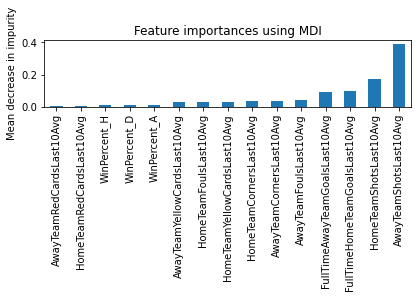

In [42]:
#Most important features in decision tree
hometree = RandomForestRegressor(n_estimators=50, random_state=42)
hometree = hometree.fit(X_train, y_train)

importances = hometree.feature_importances_

feature_names = list(X_train.columns.values)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Unsurprisingly, the number of shots and goals from each team are the most important predictors of which team will win the game.